In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Apr  9 20:25:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:

!pip -qqq install pydub
!pip -qqq install tensorboard
!pip -qqq install visualkeras
!pip -qqq install --upgrade keras
!pip -qqq install --upgrade keras tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 96.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.19.0 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.19.0 which is incompatible.


In [ ]:
import os
import math
import numpy as np
import librosa
import json
import pandas as pd
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import visualkeras
from keras.utils import plot_model
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm
from sklearn.svm import SVC
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Audio
from scipy.io import wavfile
import scipy
import soundfile as sf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report
from pydub import AudioSegment
import random

import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from pydub import AudioSegment
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
base_dir = '/content/drive/MyDrive/ASE_Dataset_Folder'
#sound_dir = os.path.join(base_dir, 'Sound_1_Sec_5_Files')

image_dir = os.path.join(base_dir,  'STFT_Images_1_Sec')
train_dir = os.path.join(image_dir, 'Train/Sounds')
test_dir = os.path.join(image_dir, 'Test/Sounds')

# Check if the train_dir exists
if os.path.exists(image_dir):
  if os.path.exists(train_dir):
    if os.path.exists(test_dir):
      print(f"train_dir exists: {image_dir}")
  else:
    print(f"train_dir does not exist: {train_dir}")

#train_dir = r"/content/drive/MyDrive/ASE_Dataset_Folder/Images_1_Sec/Train"
#test_dir = r"/content/drive/MyDrive/ASE_Dataset_Folder/Images_1_Sec/Test"



# List files in the train directory
train_files = os.listdir(train_dir)
print(f"Files in train directory: {train_files}")  # Print first all files
print(f"Total of files in Train Directory are :", len(train_files))

# List files in the test directory
test_files = os.listdir(test_dir)
print(f"Files in test directory: {test_files}")  # Print first all files
print(f"Total of files in Test Directory are :", len(test_files))



train_dir exists: /content/drive/MyDrive/ASE_Dataset_Folder/STFT_Images_1_Sec
Files in train directory: ['Explosion', 'Emergency_alarm', 'Gun_Shots', 'glass_breaking', 'thunderstorm', 'dog', 'wind', 'Earthquake', 'Flood', 'Tsunami', 'Volcanic Eruption', 'Dam Failure', 'Wildfire']
Total of files in Train Directory are : 13
Files in test directory: ['Gun_Shots', 'Emergency_alarm', 'Explosion', 'dog', 'glass_breaking', 'thunderstorm', 'wind', 'Flood', 'Earthquake', 'Tsunami', 'Volcanic Eruption', 'Dam Failure', 'Wildfire']
Total of files in Test Directory are : 13


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import numpy as np
import os
import tensorflow as tf

# Configuration
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1

hop_size_sec = hop_length / sr
audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)
channels = 3
batch_size = 32
epochs = 180

# Image Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# Check data
if len(train_generator) == 0:
    raise ValueError(f"Train generator is empty. Check the directory: {train_dir}")
if len(test_generator) == 0:
    raise ValueError(f"Test generator is empty. Check the directory: {test_dir}")

# CNN Model
cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

# Compile model with only accuracy; other metrics will be computed manually
cnn_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Training Loop
metrics_data = []

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")

    train_generator.reset()

    history = cnn_model.fit(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=1,
        validation_data=test_generator,
        validation_steps=len(test_generator),
        verbose=1
    )

    accuracy = history.history['accuracy'][0]
    val_accuracy = history.history['val_accuracy'][0]

    print(f"Train Accuracy: {accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}")
    metrics_data.append([epoch + 1, accuracy, val_accuracy])

# Save Model
cnn_model.save('/content/drive/MyDrive/CNN/STFT_CNN_DATA/al-emadi_cnn_stft_standardized_unknown_1_test.keras')


Found 3015 images belonging to 13 classes.
Found 1351 images belonging to 13 classes.

Epoch 1/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 1986s 21s/step - accuracy: 0.3740 - loss: 1.9481 - val_accuracy: 0.6551 - val_loss: 1.0698
Train Accuracy: 0.4866, Val Accuracy: 0.6551

Epoch 2/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 541ms/step - accuracy: 0.6076 - loss: 1.1915 - val_accuracy: 0.6736 - val_loss: 1.0044
Train Accuracy: 0.6259, Val Accuracy: 0.6736

Epoch 3/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 537ms/step - accuracy: 0.6429 - loss: 1.0669 - val_accuracy: 0.6617 - val_loss: 1.0230
Train Accuracy: 0.6597, Val Accuracy: 0.6617

Epoch 4/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 51s 539ms/step - accuracy: 0.6861 - loss: 0.9540 - val_accuracy: 0.7424 - val_loss: 0.8186
Train Accuracy: 0.6819, Val Accuracy: 0.7424

Epoch 5/180
95/95 ━━━━━━━━━━━━━━━━━━━━ 52s 546ms/step - accuracy: 0.6860 - loss: 0.9123 - val_accuracy: 0.7202 - val_loss: 0.8153
Train Accuracy: 0.6965, Val Accuracy: 0.7202

Epoch 6/180
95/95 ━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
df_metrics = pd.DataFrame(metrics_data, columns=["Epoch", "Train Accuracy", "Validation Accuracy"])
df_metrics.to_csv('/content/drive/MyDrive/CNN/STFT_CNN_DATA/metrics.csv', index=False)


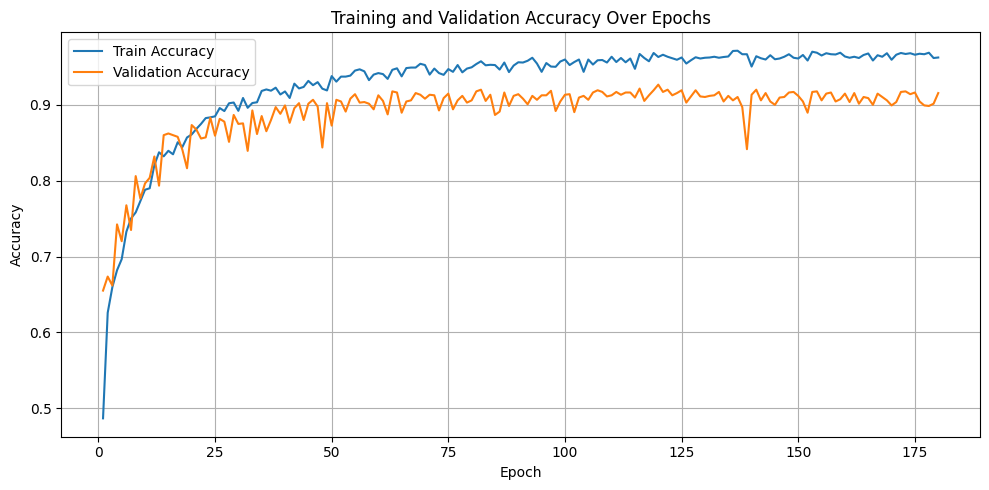

⚠️ Loss values not found in CSV. Skipping loss plot.


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV
csv_path = '/content/drive/MyDrive/CNN/STFT_CNN_DATA/metrics.csv'
df = pd.read_csv(csv_path)

# --- Accuracy Plot ---
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Train Accuracy'], label='Train Accuracy')
plt.plot(df['Epoch'], df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Loss Plot (optional) ---
if 'Train Loss' in df.columns and 'Validation Loss' in df.columns:
    plt.figure(figsize=(10, 5))
    plt.plot(df['Epoch'], df['Train Loss'], label='Train Loss')
    plt.plot(df['Epoch'], df['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Loss values not found in CSV. Skipping loss plot.")


Found 1351 images belonging to 13 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 311ms/step - accuracy: 0.8827 - loss: 0.6024

✅ Model Evaluation:
Test Loss: 0.4524
Test Accuracy: 0.9156
43/43 ━━━━━━━━━━━━━━━━━━━━ 14s 310ms/step

📊 Confusion Matrix:
[[  5   6   0   0   0   0   0   1   1   0   0   0   0]
 [  1 167   0   4   0   1   0   1   1   1   7   0   2]
 [  0   0 120   0   0   0   1   0   0   2   0   1   0]
 [  0   2   4  56   1   0   0   0   1   1   6   6   1]
 [  0   0   0   0  69   0   0   0   0   0   6   0   1]
 [  0   2   0   1   1  30   0   0   0   0   0   0   1]
 [  0   0   0   0   0   0  86   1   0   0   1   0   1]
 [  0   3   0   3   1   0   3  91   0   0   2   7   1]
 [  0   0   0   0   0   0   0   0 400   0   0   0   0]
 [  0   1   3   0   0   0   0   0   0  43   6   0   3]
 [  0   0   0   0   0   1   1   0   0   3  55   0   0]
 [  0   4   0   1   0   2   0   0   0   0   0  51   0]
 [  0   0   0   0   0   0   0   0   1   0   0   1  64]]

🎯 Accuracy for Each Class:
Dam Failure: 0.3846
Earthquake: 0.9027
Emergency_alarm: 

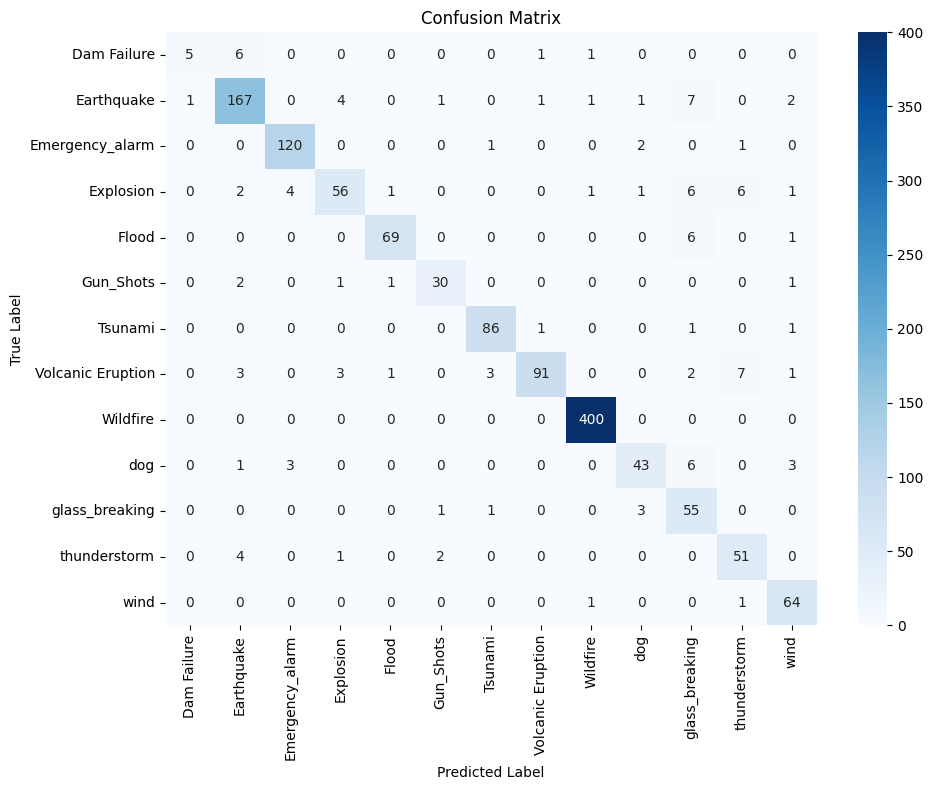

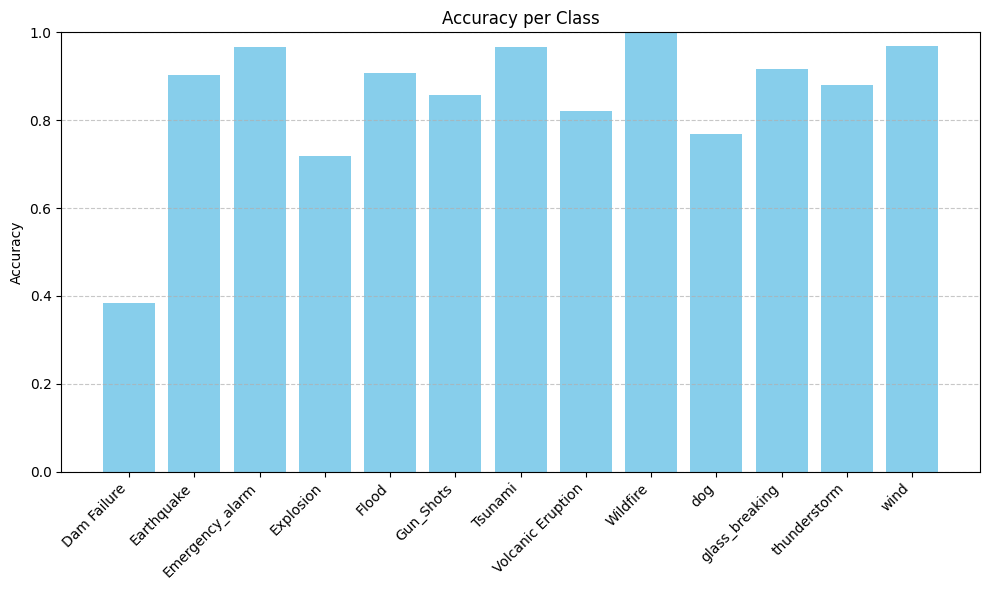

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- Configuration ---
num_classes = 13
height = 128
n_fft = 2048
hop_length = 256
sr = 22050
T = 1
channels = 3
batch_size = 32

audio_length_samples = T * sr
width = 1 + int((audio_length_samples - n_fft) / hop_length)

# --- Load model ---
model = tf.keras.models.load_model('/content/drive/MyDrive/CNN/STFT_CNN_DATA/al-emadi_cnn_stft_standardized_unknown_1_test.keras')

# --- Prepare test data ---
test_dir = '/content/drive/MyDrive/ASE_Dataset_Folder/STFT_Images_1_Sec/Test/Sounds'
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

# --- Evaluate Model ---
loss, accuracy = model.evaluate(test_generator)
print("\n✅ Model Evaluation:")
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# --- Predictions ---
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(true_classes, predicted_classes)
print("\n📊 Confusion Matrix:")
print(conf_matrix)

# --- Per-Class Accuracy ---
class_accuracy = {}
for i, class_label in enumerate(class_labels):
    correct_indices = np.where(true_classes == i)[0]
    correct_predictions = np.sum(predicted_classes[correct_indices] == i)
    total_samples = len(correct_indices)
    class_accuracy[class_label] = correct_predictions / total_samples if total_samples > 0 else 0.0

print("\n🎯 Accuracy for Each Class:")
for label in class_labels:
    print(f"{label}: {class_accuracy[label]:.4f}")

# --- Classification Report ---
print("\n📄 Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# -----------------------------
# 📊 VISUALIZATION SECTION
# -----------------------------

# 1. Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# 2. Per-Class Accuracy Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(class_accuracy.keys(), class_accuracy.values(), color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Accuracy per Class')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
